In [1]:
!git clone https://github.com/kuhung/SSD_keras

Cloning into 'SSD_keras'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 440 (delta 0), reused 9 (delta 0), pack-reused 431
Receiving objects: 100% (440/440), 1.22 GiB | 32.17 MiB/s, done.
Resolving deltas: 100% (185/185), done.


In [2]:
cd SSD_keras/

/content/SSD_keras


In [0]:
"""Some special pupropse layers for SSD."""

import keras.backend as K
from keras.engine.topology import InputSpec
from keras.engine.topology import Layer
import numpy as np
import tensorflow as tf


class Normalize(Layer):
    """Normalization layer as described in ParseNet paper.
    # Arguments
        scale: Default feature scale.
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.
    # Output shape
        Same as input
    # References
        http://cs.unc.edu/~wliu/papers/parsenet.pdf
    #TODO
        Add possibility to have one scale for all features.
    """
    def __init__(self, scale, **kwargs):
        if K.image_dim_ordering() == 'tf':
            self.axis = 3
        else:
            self.axis = 1
        self.scale = scale
        super(Normalize, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (input_shape[self.axis],)
        init_gamma = self.scale * np.ones(shape)
        self.gamma = K.variable(init_gamma, name='{}_gamma'.format(self.name))
        self.trainable_weights = [self.gamma]

    def call(self, x, mask=None):
        output = K.l2_normalize(x, self.axis)
        output *= self.gamma
        return output


class PriorBox(Layer):
    """Generate the prior boxes of designated sizes and aspect ratios.
    # Arguments
        img_size: Size of the input image as tuple (w, h).
        min_size: Minimum box size in pixels.
        max_size: Maximum box size in pixels.
        aspect_ratios: List of aspect ratios of boxes.
        flip: Whether to consider reverse aspect ratios.
        variances: List of variances for x, y, w, h.
        clip: Whether to clip the prior's coordinates
            such that they are within [0, 1].
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.
    # Output shape
        3D tensor with shape:
        (samples, num_boxes, 8)
    # References
        https://arxiv.org/abs/1512.02325
    #TODO
        Add possibility not to have variances.
        Add Theano support
    """
    def __init__(self, img_size, min_size, max_size=None, aspect_ratios=None,
                 flip=True, variances=[0.1], clip=True, **kwargs):
        if K.image_dim_ordering() == 'tf':
            self.waxis = 2
            self.haxis = 1
        else:
            self.waxis = 3
            self.haxis = 2
        self.img_size = img_size
        if min_size <= 0:
            raise Exception('min_size must be positive.')
        self.min_size = min_size
        self.max_size = max_size
        self.aspect_ratios = [1.0]
        if max_size:
            if max_size < min_size:
                raise Exception('max_size must be greater than min_size.')
            self.aspect_ratios.append(1.0)
        if aspect_ratios:
            for ar in aspect_ratios:
                if ar in self.aspect_ratios:
                    continue
                self.aspect_ratios.append(ar)
                if flip:
                    self.aspect_ratios.append(1.0 / ar)
        self.variances = np.array(variances)
        self.clip = True
        super(PriorBox, self).__init__(**kwargs)

    def get_output_shape_for(self, input_shape):
        num_priors_ = len(self.aspect_ratios)
        layer_width = input_shape[self.waxis]
        layer_height = input_shape[self.haxis]
        num_boxes = num_priors_ * layer_width * layer_height
        return (input_shape[0], num_boxes, 8)

    def call(self, x, mask=None):
        if hasattr(x, '_keras_shape'):
            input_shape = x._keras_shape
        elif hasattr(K, 'int_shape'):
            input_shape = K.int_shape(x)
        layer_width = input_shape[self.waxis]
        layer_height = input_shape[self.haxis]
        img_width = self.img_size[0]
        img_height = self.img_size[1]
        # define prior boxes shapes
        box_widths = []
        box_heights = []
        for ar in self.aspect_ratios:
            if ar == 1 and len(box_widths) == 0:
                box_widths.append(self.min_size)
                box_heights.append(self.min_size)
            elif ar == 1 and len(box_widths) > 0:
                box_widths.append(np.sqrt(self.min_size * self.max_size))
                box_heights.append(np.sqrt(self.min_size * self.max_size))
            elif ar != 1:
                box_widths.append(self.min_size * np.sqrt(ar))
                box_heights.append(self.min_size / np.sqrt(ar))
        box_widths = 0.5 * np.array(box_widths)
        box_heights = 0.5 * np.array(box_heights)
        # define centers of prior boxes
        step_x = img_width / layer_width
        step_y = img_height / layer_height
        linx = np.linspace(0.5 * step_x, img_width - 0.5 * step_x,
                           layer_width)
        liny = np.linspace(0.5 * step_y, img_height - 0.5 * step_y,
                           layer_height)
        centers_x, centers_y = np.meshgrid(linx, liny)
        centers_x = centers_x.reshape(-1, 1)
        centers_y = centers_y.reshape(-1, 1)
        # define xmin, ymin, xmax, ymax of prior boxes
        num_priors_ = len(self.aspect_ratios)
        prior_boxes = np.concatenate((centers_x, centers_y), axis=1)
        prior_boxes = np.tile(prior_boxes, (1, 2 * num_priors_))
        prior_boxes[:, ::4] -= box_widths
        prior_boxes[:, 1::4] -= box_heights
        prior_boxes[:, 2::4] += box_widths
        prior_boxes[:, 3::4] += box_heights
        prior_boxes[:, ::2] /= img_width
        prior_boxes[:, 1::2] /= img_height
        prior_boxes = prior_boxes.reshape(-1, 4)
        if self.clip:
            prior_boxes = np.minimum(np.maximum(prior_boxes, 0.0), 1.0)
        # define variances
        num_boxes = len(prior_boxes)
        if len(self.variances) == 1:
            variances = np.ones((num_boxes, 4)) * self.variances[0]
        elif len(self.variances) == 4:
            variances = np.tile(self.variances, (num_boxes, 1))
        else:
            raise Exception('Must provide one or four variances.')
        prior_boxes = np.concatenate((prior_boxes, variances), axis=1)
        prior_boxes_tensor = K.expand_dims(K.variable(prior_boxes), 0)
        if K.backend() == 'tensorflow':
            pattern = [tf.shape(x)[0], 1, 1]
            prior_boxes_tensor = tf.tile(prior_boxes_tensor, pattern)
        elif K.backend() == 'theano':
            #TODO
            pass
        return prior_boxes_tensor

In [0]:
"""Keras implementation of SSD."""

import keras.backend as K
from keras.layers import Activation
from keras.layers import AtrousConvolution2D
from keras.layers import Convolution2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import merge
from keras.layers import Reshape
from keras.layers import ZeroPadding2D
from keras.models import Model



def SSD300(input_shape, num_classes=21):
    """SSD300 architecture.
    # Arguments
        input_shape: Shape of the input image,
            expected to be either (300, 300, 3) or (3, 300, 300)(not tested).
        num_classes: Number of classes including background.
    # References
        https://arxiv.org/abs/1512.02325
    """
    net = {}
    # Block 1
    input_tensor = input_tensor = Input(shape=input_shape)
    img_size = (input_shape[1], input_shape[0])
    net['input'] = input_tensor
    net['conv1_1'] = Convolution2D(64, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv1_1')(net['input'])
    net['conv1_2'] = Convolution2D(64, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv1_2')(net['conv1_1'])
    net['pool1'] = MaxPooling2D((2, 2), strides=(2, 2), border_mode='same',
                                name='pool1')(net['conv1_2'])
    # Block 2
    net['conv2_1'] = Convolution2D(128, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv2_1')(net['pool1'])
    net['conv2_2'] = Convolution2D(128, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv2_2')(net['conv2_1'])
    net['pool2'] = MaxPooling2D((2, 2), strides=(2, 2), border_mode='same',
                                name='pool2')(net['conv2_2'])
    # Block 3
    net['conv3_1'] = Convolution2D(256, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv3_1')(net['pool2'])
    net['conv3_2'] = Convolution2D(256, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv3_2')(net['conv3_1'])
    net['conv3_3'] = Convolution2D(256, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv3_3')(net['conv3_2'])
    net['pool3'] = MaxPooling2D((2, 2), strides=(2, 2), border_mode='same',
                                name='pool3')(net['conv3_3'])
    # Block 4
    net['conv4_1'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv4_1')(net['pool3'])
    net['conv4_2'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv4_2')(net['conv4_1'])
    net['conv4_3'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv4_3')(net['conv4_2'])
    net['pool4'] = MaxPooling2D((2, 2), strides=(2, 2), border_mode='same',
                                name='pool4')(net['conv4_3'])
    # Block 5
    net['conv5_1'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv5_1')(net['pool4'])
    net['conv5_2'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv5_2')(net['conv5_1'])
    net['conv5_3'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv5_3')(net['conv5_2'])
    net['pool5'] = MaxPooling2D((3, 3), strides=(1, 1), border_mode='same',
                                name='pool5')(net['conv5_3'])
    # FC6
    net['fc6'] = AtrousConvolution2D(1024, 3, 3, atrous_rate=(6, 6),
                                     activation='relu', border_mode='same',
                                     name='fc6')(net['pool5'])
    # x = Dropout(0.5, name='drop6')(x)
    # FC7
    net['fc7'] = Convolution2D(1024, 1, 1, activation='relu',
                               border_mode='same', name='fc7')(net['fc6'])
    # x = Dropout(0.5, name='drop7')(x)
    # Block 6
    net['conv6_1'] = Convolution2D(256, 1, 1, activation='relu',
                                   border_mode='same',
                                   name='conv6_1')(net['fc7'])
    net['conv6_2'] = Convolution2D(512, 3, 3, subsample=(2, 2),
                                   activation='relu', border_mode='same',
                                   name='conv6_2')(net['conv6_1'])
    # Block 7
    net['conv7_1'] = Convolution2D(128, 1, 1, activation='relu',
                                   border_mode='same',
                                   name='conv7_1')(net['conv6_2'])
    net['conv7_2'] = ZeroPadding2D()(net['conv7_1'])
    net['conv7_2'] = Convolution2D(256, 3, 3, subsample=(2, 2),
                                   activation='relu', border_mode='valid',
                                   name='conv7_2')(net['conv7_2'])
    # Block 8
    net['conv8_1'] = Convolution2D(128, 1, 1, activation='relu',
                                   border_mode='same',
                                   name='conv8_1')(net['conv7_2'])
    net['conv8_2'] = Convolution2D(256, 3, 3, subsample=(2, 2),
                                   activation='relu', border_mode='same',
                                   name='conv8_2')(net['conv8_1'])
    # Last Pool
    net['pool6'] = GlobalAveragePooling2D(name='pool6')(net['conv8_2'])
    # Prediction from conv4_3
    net['conv4_3_norm'] = Normalize(20, name='conv4_3_norm')(net['conv4_3'])
    num_priors = 3
    x = Convolution2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv4_3_norm_mbox_loc')(net['conv4_3_norm'])
    net['conv4_3_norm_mbox_loc'] = x
    flatten = Flatten(name='conv4_3_norm_mbox_loc_flat')
    net['conv4_3_norm_mbox_loc_flat'] = flatten(net['conv4_3_norm_mbox_loc'])
    name = 'conv4_3_norm_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Convolution2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv4_3_norm'])
    net['conv4_3_norm_mbox_conf'] = x
    flatten = Flatten(name='conv4_3_norm_mbox_conf_flat')
    net['conv4_3_norm_mbox_conf_flat'] = flatten(net['conv4_3_norm_mbox_conf'])
    priorbox = PriorBox(img_size, 30.0, aspect_ratios=[2],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv4_3_norm_mbox_priorbox')
    net['conv4_3_norm_mbox_priorbox'] = priorbox(net['conv4_3_norm'])
    # Prediction from fc7
    num_priors = 6
    net['fc7_mbox_loc'] = Convolution2D(num_priors * 4, 3, 3,
                                        border_mode='same',
                                        name='fc7_mbox_loc')(net['fc7'])
    flatten = Flatten(name='fc7_mbox_loc_flat')
    net['fc7_mbox_loc_flat'] = flatten(net['fc7_mbox_loc'])
    name = 'fc7_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    net['fc7_mbox_conf'] = Convolution2D(num_priors * num_classes, 3, 3,
                                         border_mode='same',
                                         name=name)(net['fc7'])
    flatten = Flatten(name='fc7_mbox_conf_flat')
    net['fc7_mbox_conf_flat'] = flatten(net['fc7_mbox_conf'])
    priorbox = PriorBox(img_size, 60.0, max_size=114.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='fc7_mbox_priorbox')
    net['fc7_mbox_priorbox'] = priorbox(net['fc7'])
    # Prediction from conv6_2
    num_priors = 6
    x = Convolution2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv6_2_mbox_loc')(net['conv6_2'])
    net['conv6_2_mbox_loc'] = x
    flatten = Flatten(name='conv6_2_mbox_loc_flat')
    net['conv6_2_mbox_loc_flat'] = flatten(net['conv6_2_mbox_loc'])
    name = 'conv6_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Convolution2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv6_2'])
    net['conv6_2_mbox_conf'] = x
    flatten = Flatten(name='conv6_2_mbox_conf_flat')
    net['conv6_2_mbox_conf_flat'] = flatten(net['conv6_2_mbox_conf'])
    priorbox = PriorBox(img_size, 114.0, max_size=168.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv6_2_mbox_priorbox')
    net['conv6_2_mbox_priorbox'] = priorbox(net['conv6_2'])
    # Prediction from conv7_2
    num_priors = 6
    x = Convolution2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv7_2_mbox_loc')(net['conv7_2'])
    net['conv7_2_mbox_loc'] = x
    flatten = Flatten(name='conv7_2_mbox_loc_flat')
    net['conv7_2_mbox_loc_flat'] = flatten(net['conv7_2_mbox_loc'])
    name = 'conv7_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Convolution2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv7_2'])
    net['conv7_2_mbox_conf'] = x
    flatten = Flatten(name='conv7_2_mbox_conf_flat')
    net['conv7_2_mbox_conf_flat'] = flatten(net['conv7_2_mbox_conf'])
    priorbox = PriorBox(img_size, 168.0, max_size=222.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv7_2_mbox_priorbox')
    net['conv7_2_mbox_priorbox'] = priorbox(net['conv7_2'])
    # Prediction from conv8_2
    num_priors = 6
    x = Convolution2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv8_2_mbox_loc')(net['conv8_2'])
    net['conv8_2_mbox_loc'] = x
    flatten = Flatten(name='conv8_2_mbox_loc_flat')
    net['conv8_2_mbox_loc_flat'] = flatten(net['conv8_2_mbox_loc'])
    name = 'conv8_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Convolution2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv8_2'])
    net['conv8_2_mbox_conf'] = x
    flatten = Flatten(name='conv8_2_mbox_conf_flat')
    net['conv8_2_mbox_conf_flat'] = flatten(net['conv8_2_mbox_conf'])
    priorbox = PriorBox(img_size, 222.0, max_size=276.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv8_2_mbox_priorbox')
    net['conv8_2_mbox_priorbox'] = priorbox(net['conv8_2'])
    # Prediction from pool6
    num_priors = 6
    x = Dense(num_priors * 4, name='pool6_mbox_loc_flat')(net['pool6'])
    net['pool6_mbox_loc_flat'] = x
    name = 'pool6_mbox_conf_flat'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Dense(num_priors * num_classes, name=name)(net['pool6'])
    net['pool6_mbox_conf_flat'] = x
    priorbox = PriorBox(img_size, 276.0, max_size=330.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='pool6_mbox_priorbox')
    if K.image_dim_ordering() == 'tf':
        target_shape = (1, 1, 256)
    else:
        target_shape = (256, 1, 1)
    net['pool6_reshaped'] = Reshape(target_shape,
                                    name='pool6_reshaped')(net['pool6'])
    net['pool6_mbox_priorbox'] = priorbox(net['pool6_reshaped'])
    # Gather all predictions
    net['mbox_loc'] = merge([net['conv4_3_norm_mbox_loc_flat'],
                             net['fc7_mbox_loc_flat'],
                             net['conv6_2_mbox_loc_flat'],
                             net['conv7_2_mbox_loc_flat'],
                             net['conv8_2_mbox_loc_flat'],
                             net['pool6_mbox_loc_flat']],
                            mode='concat', concat_axis=1, name='mbox_loc')
    net['mbox_conf'] = merge([net['conv4_3_norm_mbox_conf_flat'],
                              net['fc7_mbox_conf_flat'],
                              net['conv6_2_mbox_conf_flat'],
                              net['conv7_2_mbox_conf_flat'],
                              net['conv8_2_mbox_conf_flat'],
                              net['pool6_mbox_conf_flat']],
                             mode='concat', concat_axis=1, name='mbox_conf')
    net['mbox_priorbox'] = merge([net['conv4_3_norm_mbox_priorbox'],
                                  net['fc7_mbox_priorbox'],
                                  net['conv6_2_mbox_priorbox'],
                                  net['conv7_2_mbox_priorbox'],
                                  net['conv8_2_mbox_priorbox'],
                                  net['pool6_mbox_priorbox']],
                                 mode='concat', concat_axis=1,
                                 name='mbox_priorbox')
    if hasattr(net['mbox_loc'], '_keras_shape'):
        num_boxes = net['mbox_loc']._keras_shape[-1] // 4
    elif hasattr(net['mbox_loc'], 'int_shape'):
        num_boxes = K.int_shape(net['mbox_loc'])[-1] // 4
    net['mbox_loc'] = Reshape((num_boxes, 4),
                              name='mbox_loc_final')(net['mbox_loc'])
    net['mbox_conf'] = Reshape((num_boxes, num_classes),
                               name='mbox_conf_logits')(net['mbox_conf'])
    net['mbox_conf'] = Activation('softmax',
                                  name='mbox_conf_final')(net['mbox_conf'])
    net['predictions'] = merge([net['mbox_loc'],
                               net['mbox_conf'],
                               net['mbox_priorbox']],
                               mode='concat', concat_axis=2,
                               name='predictions')
    model = Model(net['input'], net['predictions'])
    return model

In [0]:
"""Some utils for SSD."""

import numpy as np
import tensorflow as tf


class BBoxUtility(object):
    """Utility class to do some stuff with bounding boxes and priors.
    # Arguments
        num_classes: Number of classes including background.
        priors: Priors and variances, numpy tensor of shape (num_priors, 8),
            priors[i] = [xmin, ymin, xmax, ymax, varxc, varyc, varw, varh].
        overlap_threshold: Threshold to assign box to a prior.
        nms_thresh: Nms threshold.
        top_k: Number of total bboxes to be kept per image after nms step.
    # References
        https://arxiv.org/abs/1512.02325
    """
    # TODO add setter methods for nms_thresh and top_K
    def __init__(self, num_classes, priors=None, overlap_threshold=0.5,
                 nms_thresh=0.45, top_k=400):
        self.num_classes = num_classes
        self.priors = priors
        self.num_priors = 0 if priors is None else len(priors)
        self.overlap_threshold = overlap_threshold
        self._nms_thresh = nms_thresh
        self._top_k = top_k
        self.boxes = tf.placeholder(dtype='float32', shape=(None, 4))
        self.scores = tf.placeholder(dtype='float32', shape=(None,))
        self.nms = tf.image.non_max_suppression(self.boxes, self.scores,
                                                self._top_k,
                                                iou_threshold=self._nms_thresh)
        self.sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))

    @property
    def nms_thresh(self):
        return self._nms_thresh

    @nms_thresh.setter
    def nms_thresh(self, value):
        self._nms_thresh = value
        self.nms = tf.image.non_max_suppression(self.boxes, self.scores,
                                                self._top_k,
                                                iou_threshold=self._nms_thresh)

    @property
    def top_k(self):
        return self._top_k

    @top_k.setter
    def top_k(self, value):
        self._top_k = value
        self.nms = tf.image.non_max_suppression(self.boxes, self.scores,
                                                self._top_k,
                                                iou_threshold=self._nms_thresh)

    def iou(self, box):
        """Compute intersection over union for the box with all priors.
        # Arguments
            box: Box, numpy tensor of shape (4,).
        # Return
            iou: Intersection over union,
                numpy tensor of shape (num_priors).
        """
        # compute intersection
        inter_upleft = np.maximum(self.priors[:, :2], box[:2])
        inter_botright = np.minimum(self.priors[:, 2:4], box[2:])
        inter_wh = inter_botright - inter_upleft
        inter_wh = np.maximum(inter_wh, 0)
        inter = inter_wh[:, 0] * inter_wh[:, 1]
        # compute union
        area_pred = (box[2] - box[0]) * (box[3] - box[1])
        area_gt = (self.priors[:, 2] - self.priors[:, 0])
        area_gt *= (self.priors[:, 3] - self.priors[:, 1])
        union = area_pred + area_gt - inter
        # compute iou
        iou = inter / union
        return iou

    def encode_box(self, box, return_iou=True):
        """Encode box for training, do it only for assigned priors.
        # Arguments
            box: Box, numpy tensor of shape (4,).
            return_iou: Whether to concat iou to encoded values.
        # Return
            encoded_box: Tensor with encoded box
                numpy tensor of shape (num_priors, 4 + int(return_iou)).
        """
        iou = self.iou(box)
        encoded_box = np.zeros((self.num_priors, 4 + return_iou))
        assign_mask = iou > self.overlap_threshold
        if not assign_mask.any():
            assign_mask[iou.argmax()] = True
        if return_iou:
            encoded_box[:, -1][assign_mask] = iou[assign_mask]
        assigned_priors = self.priors[assign_mask]
        box_center = 0.5 * (box[:2] + box[2:])
        box_wh = box[2:] - box[:2]
        assigned_priors_center = 0.5 * (assigned_priors[:, :2] +
                                        assigned_priors[:, 2:4])
        assigned_priors_wh = (assigned_priors[:, 2:4] -
                              assigned_priors[:, :2])
        # we encode variance
        encoded_box[:, :2][assign_mask] = box_center - assigned_priors_center
        encoded_box[:, :2][assign_mask] /= assigned_priors_wh
        encoded_box[:, :2][assign_mask] /= assigned_priors[:, -4:-2]
        encoded_box[:, 2:4][assign_mask] = np.log(box_wh /
                                                  assigned_priors_wh)
        encoded_box[:, 2:4][assign_mask] /= assigned_priors[:, -2:]
        return encoded_box.ravel()

    def assign_boxes(self, boxes):
        """Assign boxes to priors for training.
        # Arguments
            boxes: Box, numpy tensor of shape (num_boxes, 4 + num_classes),
                num_classes without background.
        # Return
            assignment: Tensor with assigned boxes,
                numpy tensor of shape (num_boxes, 4 + num_classes + 8),
                priors in ground truth are fictitious,
                assignment[:, -8] has 1 if prior should be penalized
                    or in other words is assigned to some ground truth box,
                assignment[:, -7:] are all 0. See loss for more details.
        """
        assignment = np.zeros((self.num_priors, 4 + self.num_classes + 8))
        assignment[:, 4] = 1.0
        if len(boxes) == 0:
            return assignment
        encoded_boxes = np.apply_along_axis(self.encode_box, 1, boxes[:, :4])
        encoded_boxes = encoded_boxes.reshape(-1, self.num_priors, 5)
        best_iou = encoded_boxes[:, :, -1].max(axis=0)
        best_iou_idx = encoded_boxes[:, :, -1].argmax(axis=0)
        best_iou_mask = best_iou > 0
        best_iou_idx = best_iou_idx[best_iou_mask]
        assign_num = len(best_iou_idx)
        encoded_boxes = encoded_boxes[:, best_iou_mask, :]
        assignment[:, :4][best_iou_mask] = encoded_boxes[best_iou_idx,
                                                         np.arange(assign_num),
                                                         :4]
        assignment[:, 4][best_iou_mask] = 0
        assignment[:, 5:-8][best_iou_mask] = boxes[best_iou_idx, 4:]
        assignment[:, -8][best_iou_mask] = 1
        return assignment

    def decode_boxes(self, mbox_loc, mbox_priorbox, variances):
        """Convert bboxes from local predictions to shifted priors.
        # Arguments
            mbox_loc: Numpy array of predicted locations.
            mbox_priorbox: Numpy array of prior boxes.
            variances: Numpy array of variances.
        # Return
            decode_bbox: Shifted priors.
        """
        prior_width = mbox_priorbox[:, 2] - mbox_priorbox[:, 0]
        prior_height = mbox_priorbox[:, 3] - mbox_priorbox[:, 1]
        prior_center_x = 0.5 * (mbox_priorbox[:, 2] + mbox_priorbox[:, 0])
        prior_center_y = 0.5 * (mbox_priorbox[:, 3] + mbox_priorbox[:, 1])
        decode_bbox_center_x = mbox_loc[:, 0] * prior_width * variances[:, 0]
        decode_bbox_center_x += prior_center_x
        decode_bbox_center_y = mbox_loc[:, 1] * prior_width * variances[:, 1]
        decode_bbox_center_y += prior_center_y
        decode_bbox_width = np.exp(mbox_loc[:, 2] * variances[:, 2])
        decode_bbox_width *= prior_width
        decode_bbox_height = np.exp(mbox_loc[:, 3] * variances[:, 3])
        decode_bbox_height *= prior_height
        decode_bbox_xmin = decode_bbox_center_x - 0.5 * decode_bbox_width
        decode_bbox_ymin = decode_bbox_center_y - 0.5 * decode_bbox_height
        decode_bbox_xmax = decode_bbox_center_x + 0.5 * decode_bbox_width
        decode_bbox_ymax = decode_bbox_center_y + 0.5 * decode_bbox_height
        decode_bbox = np.concatenate((decode_bbox_xmin[:, None],
                                      decode_bbox_ymin[:, None],
                                      decode_bbox_xmax[:, None],
                                      decode_bbox_ymax[:, None]), axis=-1)
        decode_bbox = np.minimum(np.maximum(decode_bbox, 0.0), 1.0)
        return decode_bbox

    def detection_out(self, predictions, background_label_id=0, keep_top_k=200,
                      confidence_threshold=0.01):
        """Do non maximum suppression (nms) on prediction results.
        # Arguments
            predictions: Numpy array of predicted values.
            num_classes: Number of classes for prediction.
            background_label_id: Label of background class.
            keep_top_k: Number of total bboxes to be kept per image
                after nms step.
            confidence_threshold: Only consider detections,
                whose confidences are larger than a threshold.
        # Return
            results: List of predictions for every picture. Each prediction is:
                [label, confidence, xmin, ymin, xmax, ymax]
        """
        mbox_loc = predictions[:, :, :4]
        variances = predictions[:, :, -4:]
        mbox_priorbox = predictions[:, :, -8:-4]
        mbox_conf = predictions[:, :, 4:-8]
        results = []
        for i in range(len(mbox_loc)):
            results.append([])
            decode_bbox = self.decode_boxes(mbox_loc[i],
                                            mbox_priorbox[i], variances[i])
            for c in range(self.num_classes):
                if c == background_label_id:
                    continue
                c_confs = mbox_conf[i, :, c]
                c_confs_m = c_confs > confidence_threshold
                if len(c_confs[c_confs_m]) > 0:
                    boxes_to_process = decode_bbox[c_confs_m]
                    confs_to_process = c_confs[c_confs_m]
                    feed_dict = {self.boxes: boxes_to_process,
                                 self.scores: confs_to_process}
                    idx = self.sess.run(self.nms, feed_dict=feed_dict)
                    good_boxes = boxes_to_process[idx]
                    confs = confs_to_process[idx][:, None]
                    labels = c * np.ones((len(idx), 1))
                    c_pred = np.concatenate((labels, confs, good_boxes),
                                            axis=1)
                    results[-1].extend(c_pred)
            if len(results[-1]) > 0:
                results[-1] = np.array(results[-1])
                argsort = np.argsort(results[-1][:, 1])[::-1]
                results[-1] = results[-1][argsort]
                results[-1] = results[-1][:keep_top_k]
        return results


In [7]:
#!pip3 install keras==1.2.2
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf


%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

print(cv2.__version__)
print(keras.__version__)

3.4.3
1.2.2


In [0]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1

In [0]:
input_shape=(300, 300, 3)
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('/content/SSD_keras/weights_SSD300.hdf5', by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES)

In [0]:
try:
    from PIL import Image as pil_image
except ImportError:
    pil_image = None
    

if pil_image is not None:
    _PIL_INTERPOLATION_METHODS = {
        'nearest': pil_image.NEAREST,
        'bilinear': pil_image.BILINEAR,
        'bicubic': pil_image.BICUBIC,
    }
    # These methods were only introduced in version 3.4.0 (2016).
    if hasattr(pil_image, 'HAMMING'):
        _PIL_INTERPOLATION_METHODS['hamming'] = pil_image.HAMMING
    if hasattr(pil_image, 'BOX'):
        _PIL_INTERPOLATION_METHODS['box'] = pil_image.BOX
    # This method is new in version 1.1.3 (2013).
    if hasattr(pil_image, 'LANCZOS'):
        _PIL_INTERPOLATION_METHODS['lanczos'] = pil_image.LANCZOS
    
def load_img(path, grayscale=False, target_size=None,
             interpolation='nearest'):
    """Loads an image into PIL format.
    # Arguments
        path: Path to image file
        grayscale: Boolean, whether to load the image as grayscale.
        target_size: Either `None` (default to original size)
            or tuple of ints `(img_height, img_width)`.
        interpolation: Interpolation method used to resample the image if the
            target size is different from that of the loaded image.
            Supported methods are "nearest", "bilinear", and "bicubic".
            If PIL version 1.1.3 or newer is installed, "lanczos" is also
            supported. If PIL version 3.4.0 or newer is installed, "box" and
            "hamming" are also supported. By default, "nearest" is used.
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
        ValueError: if interpolation method is not supported.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    img = pil_image.open(path)
    if grayscale:
        if img.mode != 'L':
            img = img.convert('L')
    else:
        if img.mode != 'RGB':
            img = img.convert('RGB')
    if target_size is not None:
        width_height_tuple = (target_size[1], target_size[0])
        if img.size != width_height_tuple:
            if interpolation not in _PIL_INTERPOLATION_METHODS:
                raise ValueError(
                    'Invalid interpolation method {} specified. Supported '
                    'methods are {}'.format(
                        interpolation,
                        ", ".join(_PIL_INTERPOLATION_METHODS.keys())))
            resample = _PIL_INTERPOLATION_METHODS[interpolation]
            img = img.resize(width_height_tuple, resample)
    return img

In [0]:
inputs = []
images = []
img_path = '/content/SSD_keras/pics/1.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(plt.imread(img_path))
inputs.append(img.copy())
img_path = '/content/SSD_keras/pics/2.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(plt.imread(img_path))
inputs.append(img.copy())
img_path = '/content/SSD_keras/pics/3.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(plt.imread(img_path))
inputs.append(img.copy())
img_path = '/content/SSD_keras/pics/4.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(plt.imread(img_path))
inputs.append(img.copy())
img_path = '/content/SSD_keras/pics/52.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(plt.imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [73]:
preds = model.predict(inputs, batch_size=1, verbose=1)


5/5 [==============================] - 0s     


In [0]:
results = bbox_util.detection_out(preds)


In [75]:
%%time
a = model.predict(inputs, batch_size=1)
b = bbox_util.detection_out(preds)


CPU times: user 152 ms, sys: 23.5 ms, total: 176 ms
Wall time: 388 ms


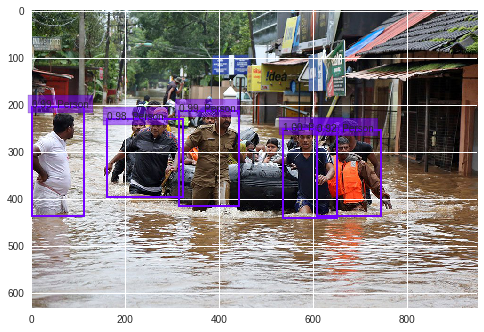

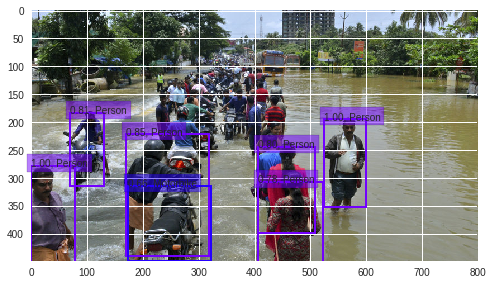

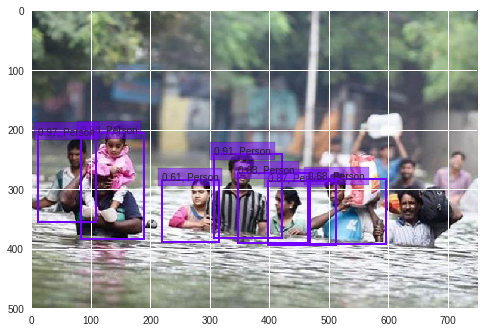

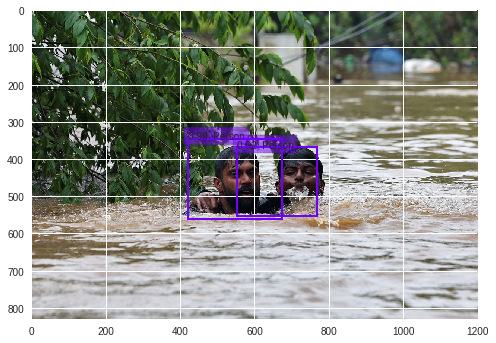

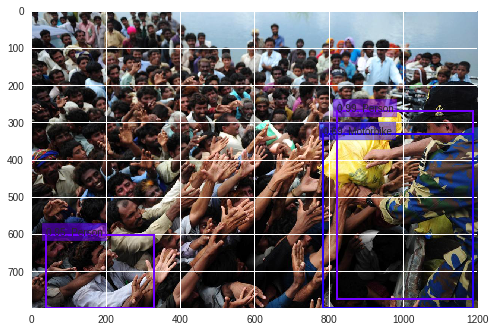

In [76]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()


In [0]:
# Video Coding 

""" A class for testing a SSD model on a video file or webcam """

import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image 
import pickle
import numpy as np
from random import shuffle
from scipy.misc import imread, imresize
from timeit import default_timer as timer

import sys
sys.path.append("..")

class VideoTest(object):
    """ Class for testing a trained SSD model on a video file and show the
        result in a window. Class is designed so that one VideoTest object 
        can be created for a model, and the same object can then be used on 
        multiple videos and webcams.
        
        Arguments:
            class_names: A list of strings, each containing the name of a class.
                         The first name should be that of the background class
                         which is not used.
                         
            model:       An SSD model. It should already be trained for 
                         images similar to the video to test on.
                         
            input_shape: The shape that the model expects for its input, 
                         as a tuple, for example (300, 300, 3)    
                         
            bbox_util:   An instance of the BBoxUtility class in ssd_utils.py
                         The BBoxUtility needs to be instantiated with 
                         the same number of classes as the length of        
                         class_names.
    
    """
    
    def __init__(self, class_names, model, input_shape):
        self.class_names = class_names
        self.num_classes = len(class_names)
        self.model = model
        self.input_shape = input_shape
        self.bbox_util = BBoxUtility(self.num_classes)
        
        # Create unique and somewhat visually distinguishable bright
        # colors for the different classes.
        self.class_colors = []
        for i in range(0, self.num_classes):
            # This can probably be written in a more elegant manner
            hue = 255*i/self.num_classes
            col = np.zeros((1,1,3)).astype("uint8")
            col[0][0][0] = hue
            col[0][0][1] = 128 # Saturation
            col[0][0][2] = 255 # Value
            cvcol = cv2.cvtColor(col, cv2.COLOR_HSV2BGR)
            col = (int(cvcol[0][0][0]), int(cvcol[0][0][1]), int(cvcol[0][0][2]))
            self.class_colors.append(col) 
        
    def run(self, video_path = 0, start_frame = 0, conf_thresh = 0.6):
        """ Runs the test on a video (or webcam)
        
        # Arguments
        video_path: A file path to a video to be tested on. Can also be a number, 
                    in which case the webcam with the same number (i.e. 0) is 
                    used instead
                    
        start_frame: The number of the first frame of the video to be processed
                     by the network. 
                     
        conf_thresh: Threshold of confidence. Any boxes with lower confidence 
                     are not visualized.
                    
        """

        vid = cv2.VideoCapture('/content/SSD_keras/video_utils/hy.mp4')
        if not vid.isOpened():
            raise IOError(("trying to open a webcam, make sure you video_path is an integer!"))
        
        skv=skvideo.io.VideoCapture('/content/SSD_keras/video_utils/hy.mp4')
        vidar = float(skv.width)/skv.height
        vidaz = float(skv.height)/self.input_shape[0]
	
        
        # Skip frames until reaching start_frame
        if start_frame > 0:
            vid.set(cv2.cv.CV_CAP_PROP_POS_MSEC, start_frame)
            
        accum_time = 0
        curr_fps = 0
        fps = "FPS: ??"
        prev_time = timer()
            
        while True:
            retval, orig_image = vid.read()
            if not retval:
                print("Done!")
                return
                
            im_size = (self.input_shape[0], self.input_shape[1])    
            resized = cv2.resize(orig_image, im_size)
            rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
            
            # Reshape to original aspect ratio for later visualization
            # The resized version is used, to visualize what kind of resolution
            # the network has to work with.
            to_draw = cv2.resize(resized, (int(self.input_shape[0]*vidar*vidaz*0.6), int(self.input_shape[1]*vidaz*0.6)))
            # Use model to predict 
            inputs = [image.img_to_array(rgb)]
            tmp_inp = np.array(inputs)
            x = preprocess_input(tmp_inp)
            
            y = self.model.predict(x)
            
            
            # This line creates a new TensorFlow device every time. Is there a 
            # way to avoid that?
            results = self.bbox_util.detection_out(y)
            
            if len(results) > 0 and len(results[0]) > 0:
                # Interpret output, only one frame is used 
                det_label = results[0][:, 0]
                det_conf = results[0][:, 1]
                det_xmin = results[0][:, 2]
                det_ymin = results[0][:, 3]
                det_xmax = results[0][:, 4]
                det_ymax = results[0][:, 5]

                top_indices = [i for i, conf in enumerate(det_conf) if conf >= conf_thresh]

                top_conf = det_conf[top_indices]
                top_label_indices = det_label[top_indices].tolist()
                top_xmin = det_xmin[top_indices]
                top_ymin = det_ymin[top_indices]
                top_xmax = det_xmax[top_indices]
                top_ymax = det_ymax[top_indices]

                for i in range(top_conf.shape[0]):
                    xmin = int(round(top_xmin[i] * to_draw.shape[1]))
                    ymin = int(round(top_ymin[i] * to_draw.shape[0]))
                    xmax = int(round(top_xmax[i] * to_draw.shape[1]))
                    ymax = int(round(top_ymax[i] * to_draw.shape[0]))

                    # Draw the box on top of the to_draw image
                    class_num = int(top_label_indices[i])
                    cv2.rectangle(to_draw, (xmin, ymin), (xmax, ymax), 
                                  self.class_colors[class_num], 2)
                    text = self.class_names[class_num] + " " + ('%.2f' % top_conf[i])

                    text_top = (xmin, ymin-10)
                    text_bot = (xmin + 80, ymin + 5)
                    text_pos = (xmin + 5, ymin)
                    cv2.rectangle(to_draw, text_top, text_bot, self.class_colors[class_num], -1)
                    cv2.putText(to_draw, text, text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,0,0), 1)
            
            # Calculate FPS
            # This computes FPS for everything, not just the model's execution 
            # which may or may not be what you want
            curr_time = timer()
            exec_time = curr_time - prev_time
            prev_time = curr_time
            accum_time = accum_time + exec_time
            curr_fps = curr_fps + 1
            if accum_time > 1:
                accum_time = accum_time - 1
                fps = "FPS: " + str(curr_fps)
                curr_fps = 0
            
            # Draw FPS in top left corner
            cv2.rectangle(to_draw, (0,0), (50, 17), (255,255,255), -1)
            cv2.putText(to_draw, fps, (3,10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,0,0), 1)
            
            cv2.imshow("SSD result", to_draw)
            cv2.waitKey(1)


In [0]:
import sys
import keras
import pickle
import sys
sys.path.append("..")

input_shape = (300,300,3)

# Change this if you run with other classes than VOC
class_names = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"];
NUM_CLASSES = len(class_names)

model = SSD300(input_shape, num_classes=NUM_CLASSES)

# Change this path if you want to use your own trained weights
model.load_weights('/content/SSD_keras/weights_SSD300.hdf5') 
        
vid_test = VideoTest(class_names, model, input_shape)

# To test on webcam 0, remove the parameter (or change it to another number
# to test on that webcam)
#vid_test.run(sys.argv[1])